In [26]:
# import cora dataset

import numpy as np
import pandas as pd
import os
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv

In [27]:
# load cora dataset
dataset = Planetoid(root='./data', name='Cora')
data = dataset[0]

In [28]:
# do a 70/10/20 split for training, validation, and testing
num_nodes = data.num_nodes
num_train = int(num_nodes * 0.7)
num_val = int(num_nodes * 0.1)
num_test = num_nodes - num_train - num_val

# randomly select training, validation, and test nodes
all_nodes = np.arange(num_nodes)
np.random.shuffle(all_nodes)
train_nodes = all_nodes[:num_train]
val_nodes = all_nodes[num_train:num_train+num_val]
test_nodes = all_nodes[num_train+num_val:]

# create masks for training, validation, and test nodes
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_nodes] = 1
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask[val_nodes] = 1
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask[test_nodes] = 1


data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

In [29]:
# create GCN model

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

In [30]:
# train the model

def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test(model, data, criterion):
    model.eval()
    out = model(data.x, data.edge_index)
    val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
    test_loss = criterion(out[data.test_mask], data.y[data.test_mask])
    return val_loss.item(), test_loss.item()


In [38]:

input_dim = data.num_features
hidden_dim = 64
output_dim = 7
model = GCN(input_dim, hidden_dim, output_dim)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

num_epochs = 100

for epoch in range(num_epochs):
    loss = train(model, data, optimizer, criterion)
    val_loss, test_loss = test(model, data, criterion)
    if epoch % 100 == 99:
        print(f'Epoch: {epoch}, Loss: {loss.item()}, Val Loss: {val_loss}, Test Loss: {test_loss}')

Epoch: 99, Loss: 0.02055380307137966, Val Loss: 0.7351097464561462, Test Loss: 0.8582122921943665


In [39]:
# test accuracy

def accuracy(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = pred[data.test_mask] == data.y[data.test_mask]
    return correct.sum().item() / data.test_mask.sum().item()

acc = accuracy(model, data)
print(f'Test Accuracy: {acc}')

Test Accuracy: 0.8397790055248618


Predicted Class: 3


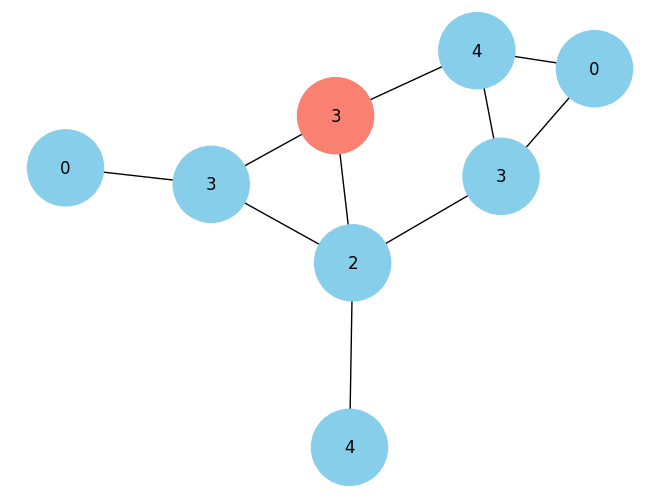

In [42]:
from torch_geometric.utils import k_hop_subgraph

def vis_neighborhood(node_idx, data, model, k):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    print(f'Predicted Class: {pred[node_idx].item()}')
    G = nx.Graph()
    
    # add the k-hop neighborhood of the node to the graph
    sub_nodes, sub_edges, mapping, _ = k_hop_subgraph(node_idx, k, data.edge_index, relabel_nodes=True)
    
    for i, feat in enumerate(data.x[sub_nodes].tolist()):
        G.add_node(i, label=pred[i].item())
        
    for edge in sub_edges.t().tolist():
        G.add_edge(edge[0], edge[1])
        
    # color the selected node differently
    node_colors = ['skyblue' if i != node_idx else 'salmon' for i in G.nodes]
        
    pos = nx.spring_layout(G)
    node_labels = nx.get_node_attributes(G, 'label')
    nx.draw(G, pos, labels=node_labels, with_labels=True, node_size=3000, node_color=node_colors)
    
    plt.show()
    
vis_neighborhood(0, data, model, 2)